# Библиотеки Python для DS (семинары)

Урок 9. Использование на практике методов снижения размерности

Использование алгоритмов понижения размерности для улучшения классификации новостей (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html)

Цель задания: Исследовать влияние различных методов понижения размерности на качество классификации текстовых данных.

Датасет: Набор данных новостных статей
(датасет '20 Newsgroups' доступный в sklearn.datasets).

Задачи:

1. Загрузите датасет '20 Newsgroups' из sklearn.

2. Проведите предобработку данных (очистка текста, удаление стоп-слов, векторизация с использованием TF-IDF).

3. Примените к полученным векторам TF-IDF следующие методы понижения размерности:
— PCA (Principal Component Analysis)
— t-SNE (t-distributed Stochastic Neighbor Embedding)
— UMAP (Uniform Manifold Approximation and Projection).

4. После понижения размерности данных используйте любой метод машинного обучения для классификации новостей по темам.

5. Сравните качество классификации для каждого метода понижения размерности. Используйте метрики точности и F1-меру.

6. Визуализируйте двумерное представление данных для каждого метода понижения размерности, чтобы оценить, как алгоритмы справляются с сепарацией классов.

7. Напишите отчёт, в котором обсудите, какой метод понижения размерности оказал наиболее значительное влияние на качество классификации и почему.


## Выполнение домашней работы

##### Используем предоставленый к заданию файл fetch_california_housing.xlsx

In [178]:
# Библиотека для загрузки датасета
from sklearn.datasets import fetch_20newsgroups
import joblib
# Библиотеки для работы с датасетом и графиками
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import umap
from umap import UMAP
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Необходимые ресурсы NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt_tab')

##### 1. Загрузите датасет '20 Newsgroups' из sklearn.

In [ ]:
# Вариант загрузки №1
# Загрузка датасета
newsgroups_data = fetch_20newsgroups(subset='all')

# Просмотр информации о датасете
print(f'Количество документов: {len(newsgroups_data.data)}')
print(f'Количество классов: {len(newsgroups_data.target_names)}')

Количество документов: 18846
Количество классов: 20


In [ ]:
# Указываем путь к папке
output_dir = '20_newsgroups_data'
os.makedirs(output_dir, exist_ok=True)

# Сохраняем документы в текстовые файлы
for i, (doc, label) in enumerate(zip(newsgroups.data, newsgroups.target)):
    # Создаем имя файла на основе индекса документа
    file_name = os.path.join(output_dir, f'document_{i}.txt')
    with open(file_name, 'w', encoding='utf-8') as f:
        f.write(doc)

# Сохраняем метки классов в отдельный файл
labels_file_path = os.path.join(output_dir, 'labels.txt')
with open(labels_file_path, 'w', encoding='utf-8') as f:
    for label in newsgroups.target:
        f.write(f'{label}\n')

print(f'Датасет сохранен в папке: {output_dir}')

Датасет сохранен в папке: 20_newsgroups_data


In [3]:
# Вариант загрузки №2
# Загрузка датасета
newsgroups_data = fetch_20newsgroups(subset='all')

# Сохранение данных в файл
joblib.dump(newsgroups_data, '20_newsgroups_data.pkl')

# Загрузка данных из файла
newsgroups_data = joblib.load('20_newsgroups_data.pkl')

Выше дредставлены два варианта загрузки DataFrame fetch_20newsgroups

In [135]:
# Создание DataFrame, предварительно нужно выбрать вариант загрузки что представлены выше
data = {
    'text': newsgroups_data.data,
    'target': newsgroups_data.target}
df = pd.DataFrame(data)

# Добавление категорий
df['category'] = df['target'].apply(lambda x: newsgroups_data.target_names[x])

# Вывод DataFrame
df

text  target  \
0      From: Mamatha Devineni Ratnam <mr47+@andrew.cm...      10   
1      From: mblawson@midway.ecn.uoknor.edu (Matthew ...       3   
2      From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...      17   
3      From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...       3   
4      From: Alexander Samuel McDiarmid <am2o+@andrew...       4   
...                                                  ...     ...   
18841  From: jim.zisfein@factory.com (Jim Zisfein) \n...      13   
18842  From: rdell@cbnewsf.cb.att.com (richard.b.dell...      12   
18843  From: westes@netcom.com (Will Estes)\nSubject:...       3   
18844  From: steve@hcrlgw (Steven Collins)\nSubject: ...       1   
18845  From: chriss@netcom.com (Chris Silvester)\nSub...       7   

                       category  
0              rec.sport.hockey  
1      comp.sys.ibm.pc.hardware  
2         talk.politics.mideast  
3      comp.sys.ibm.pc.hardware  
4         comp.sys.mac.hardware  
...                         ...  
18841                   sci.med  
18842           sci.electronics  
18843  comp.sys.ibm.pc.hardware  
18844             comp.graphics  
18845                 rec.autos  

[18846 rows x 3 columns]

##### 2. Проведите предобработку данных (очистка текста, удаление стоп-слов, векторизация с использованием TF-IDF).

In [4]:
# Выводим общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      18846 non-null  object
 1   target    18846 non-null  int32 
 2   category  18846 non-null  object
dtypes: int32(1), object(2)
memory usage: 368.2+ KB


Из общей информации следует:
1. Всего 3 колоноки, DataFrame содержит 18846 записей, от 0 до 18845
2. Нулевые значения отсуствуют
3. Пропущенные значения отсуствуют
4. Колонка target находятся в целочисленом значении int32
5. Колонки: text и category являются объектами object 

In [5]:
# Статистический анализ числовых переменных
df.describe().T

count      mean       std  min  25%  50%   75%   max
target  18846.0  9.293166  5.562798  0.0  5.0  9.0  14.0  19.0

На основе представленных статистических данных неприрывных признаков можно сделать следующие выводы:

1. target (Числовые метки классов/категорий): 
- Средние количество меток на уровне 9.00
- Миниманая 0.0
- Максимальная 19.00
- Медиана равна 9.29
- Отклонение состовляет 5.56

In [6]:
# Статистический анализ объектных признаков
df.describe(include='object').T

count unique                                                top freq
text      18846  18846  From: Mamatha Devineni Ratnam <mr47+@andrew.cm...    1
category  18846     20                                   rec.sport.hockey  999

1. text (Текст сообщения):
- В данных присутствуют записи о поле у 18846 текстов.
- Каждый текст уникален.

2. category (Категория)
- В данных присутствуют записи о поле у 18846 категории.
- В данных присутствует 20 уникальных категорий.
- Категория rec.sport.hockey встречается наиболее часто 999 раз.

In [ ]:
# Проверяем на дубликаты
print('Количество дубликатов:')
print(df.duplicated().sum())

Количество дубликатов:
0


In [8]:
# Проверка на нулевые значения
df.isnull().sum()

text        0
target      0
category    0
dtype: int64

In [9]:
# Проверка на NaN значения
df.isnull().any().any()

False

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      18846 non-null  object
 1   target    18846 non-null  int32 
 2   category  18846 non-null  object
dtypes: int32(1), object(2)
memory usage: 368.2+ KB


C:\Users\Esdesu\AppData\Local\Temp\ipykernel_15536\853446660.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='category', data=df, order=df['category'].value_counts().index, palette='viridis')


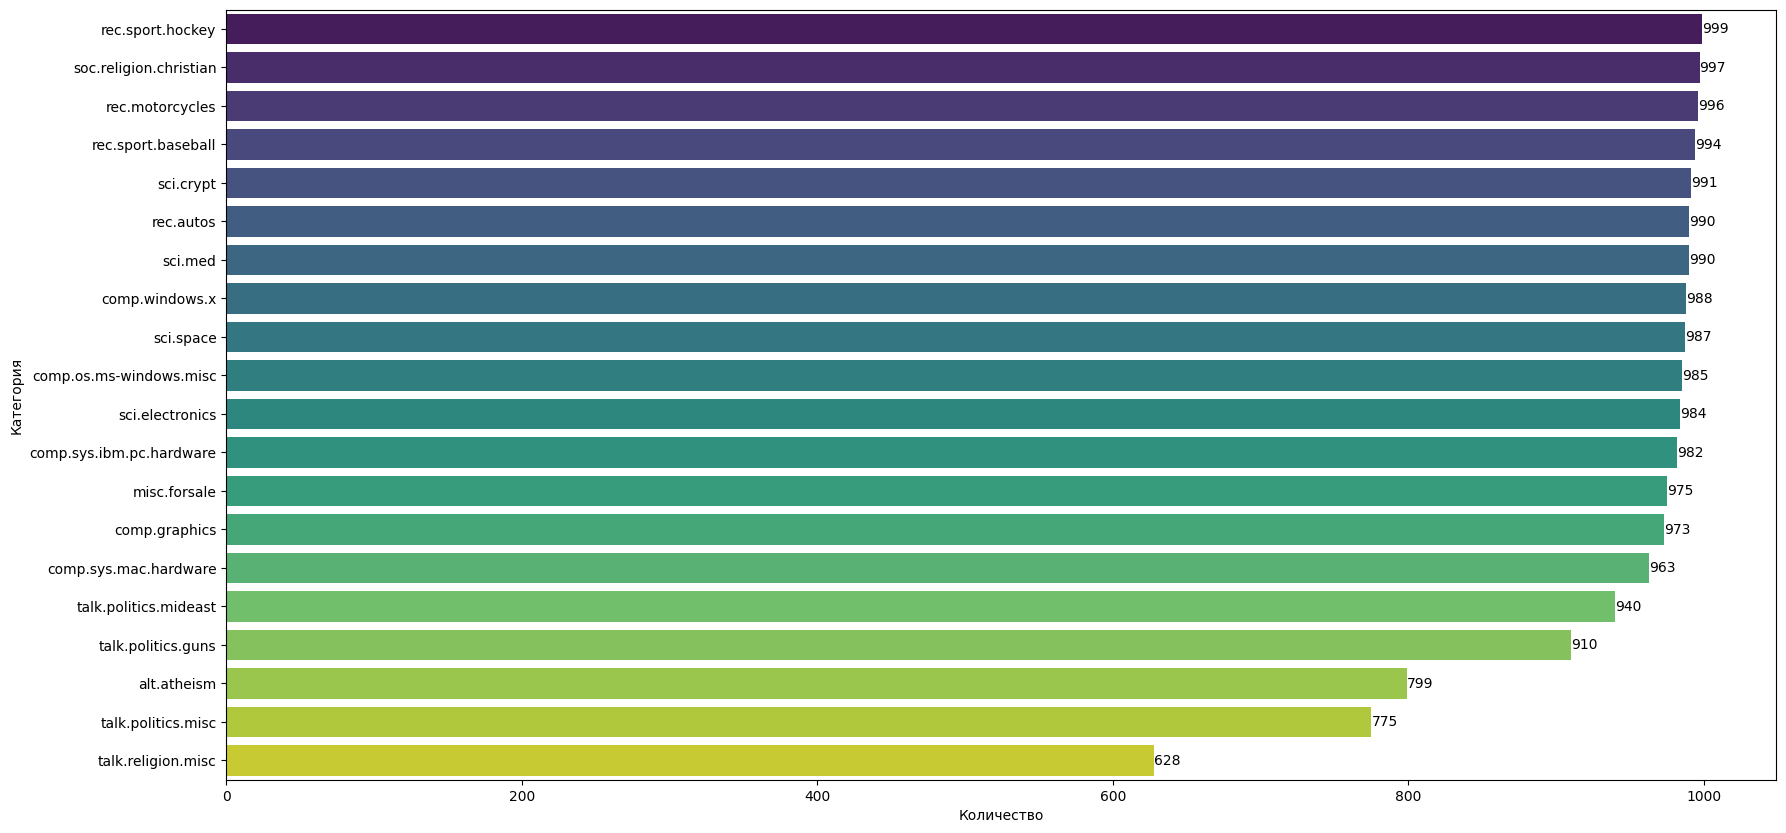

In [11]:
# Установка размера фигуры
plt.figure(figsize=(20, 10))

# Построение графика с изменениями
sns.countplot(y='category', data=df, order=df['category'].value_counts().index, palette='viridis')

# Добавление заголовков
plt.xlabel('Количество')
plt.ylabel('Категория')

# Добавление аннотаций для отображения точных значений
for index, value in enumerate(df['category'].value_counts()):
    plt.text(value, index, str(value), va='center')

# Отображение графика
plt.show()

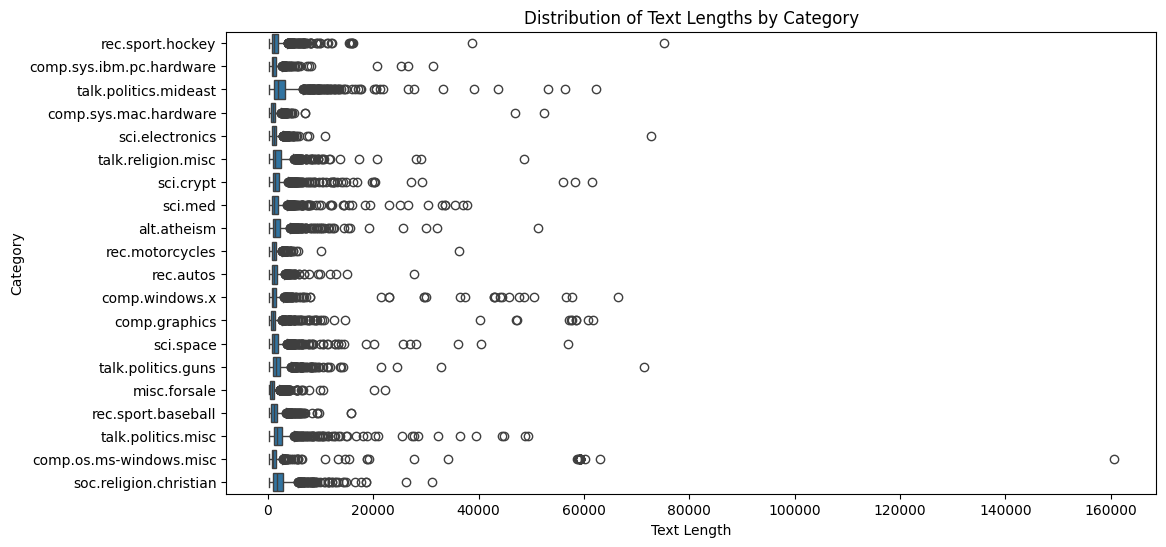

In [12]:
# Длина текстов в различных категориях
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(y='category', x='text_length', data=df, orient='h')
plt.title('Distribution of Text Lengths by Category')
plt.xlabel('Text Length')
plt.ylabel('Category')
plt.show()

C:\Users\Esdesu\AppData\Local\Temp\ipykernel_14856\2597308334.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='category', x='text_length', data=df, orient='h', palette='viridis')


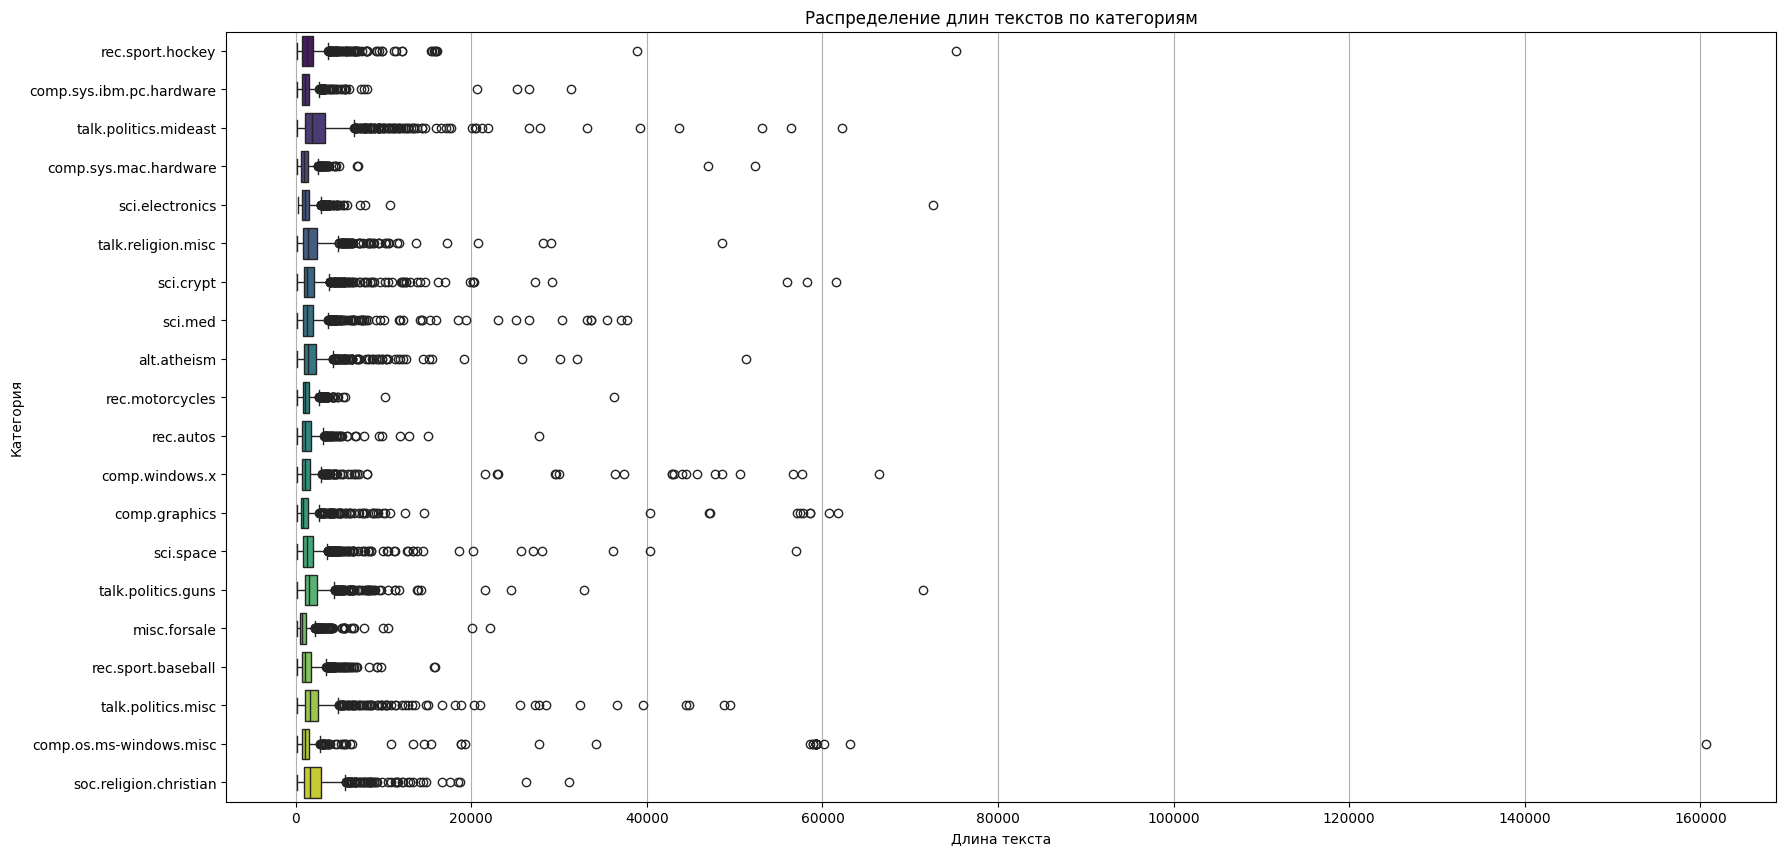

In [5]:
# Создание нового столбца для длины текстов
df['text_length'] = df['text'].apply(len)

# Установка размера фигуры
plt.figure(figsize=(20, 10))

# Построение графика с изменениями
sns.boxplot(y='category', x='text_length', data=df, orient='h', palette='viridis')

# Добавление заголовков
plt.title('Распределение длин текстов по категориям')
plt.xlabel('Длина текста')
plt.ylabel('Категория')

# Настройка сетки для лучшей читаемости
plt.grid(axis='x')

# Отображение графика
plt.show()


C:\Users\Esdesu\AppData\Local\Temp\ipykernel_14856\208279121.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data=word_freq.sort_values(by='frequency', ascending=False), palette='coolwarm')


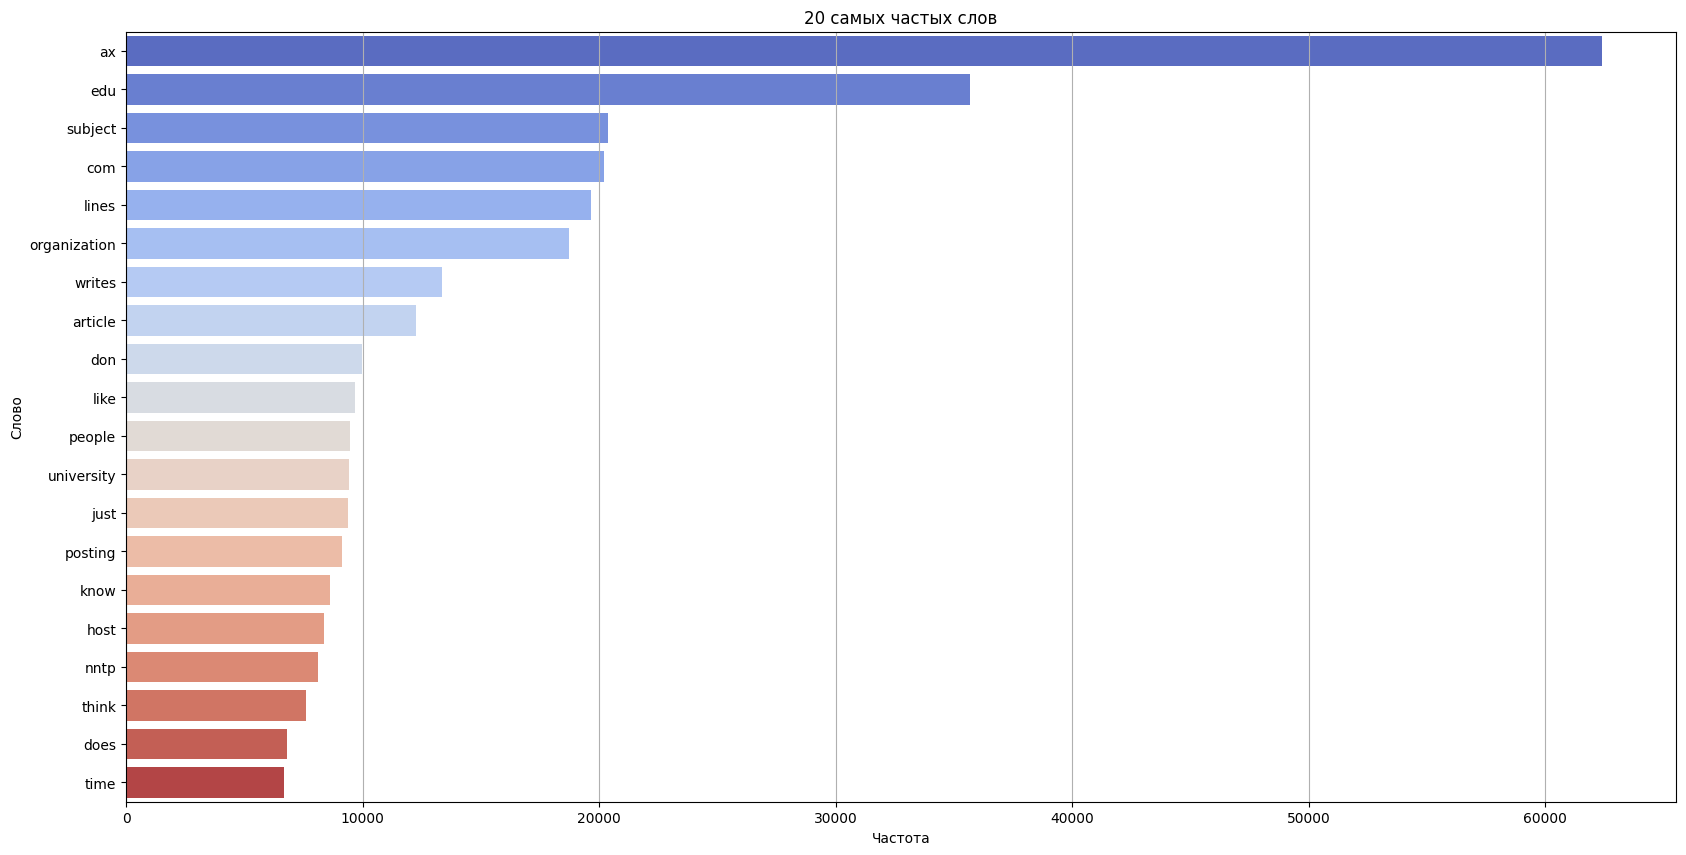

In [4]:
# Частотный анализ слов
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['text'])

# X.toarray(): Преобразует разреженную матрицу в плотный массив (numpy array), чтобы можно было легко суммировать частоты.
# sum(axis=0): Суммирует частоты слов по всем документам, создавая вектор частот,
# где каждая позиция соответствует суммарной частоте одного слова во всех документах.
# Создание DataFrame для частот слов
word_freq = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'frequency': X.toarray().sum(axis=0)
})

# Установка размера фигуры
plt.figure(figsize=(20, 10))

# Построение графика с изменениями
sns.barplot(x='frequency', y='word', data=word_freq.sort_values(by='frequency', ascending=False), palette='coolwarm')

# Добавление заголовков
plt.title('20 самых частых слов')
plt.xlabel('Частота')
plt.ylabel('Слово')

# Настройка сетки для лучшей читаемости
plt.grid(axis='x')

c:\Users\Esdesu\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


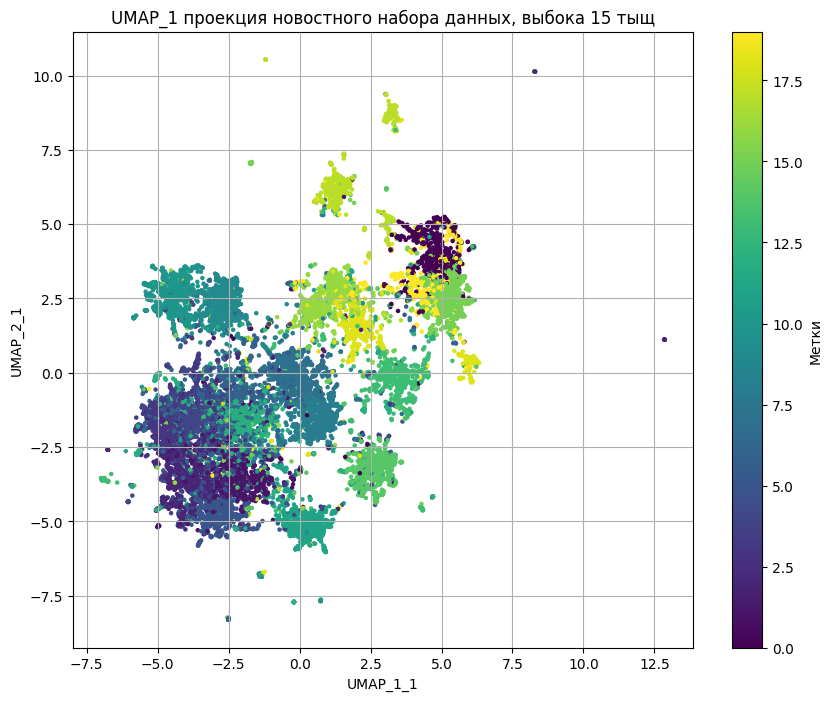

[[0.         0.97793983 0.96172526 0.99619405 0.94455895]
 [0.97793983 0.         0.99476593 0.89607056 0.98455601]
 [0.96172526 0.99476593 0.         0.98918554 0.97788479]
 [0.99619405 0.89607056 0.98918554 0.         0.92826904]
 [0.94455895 0.98455601 0.97788479 0.92826904 0.        ]]


In [ ]:
# Инициализация стоп-слов и лемматизатора
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Применение функции предобработки к текстовым данным
df = pd.DataFrame({'text': newsgroups_data.data, 'label': newsgroups_data.target})

def preprocess(text):
    '''
    Предобработка входного текста: токенизация, удаление пунктуации, 
    удаление стоп-слов и лемматизация.
    '''
    # Токенизация текста и перевод в нижний регистр
    words = word_tokenize(text.lower())
    # Удаление пунктуации
    words = [word.translate(str.maketrans('', '', string.punctuation)) for word in words]
    # Удаление стоп-слов и фильтрация по алфавиту
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_words)

# Применение функции предобработки к текстовым данным
df['cleaned_text'] = df['text'].apply(preprocess)

# Векторизация текстовых данных с помощью TF-IDF
vectorizer = TfidfVectorizer(max_features=15_000).fit(df['cleaned_text'])
features_1 = vectorizer.transform(df['cleaned_text'])

# Вычисление косинусных расстояний
cosine_distances_matrix = cosine_distances(features_1)

# Понижение размерности с помощью UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(features_1.toarray()) 

# Визуализация результатов
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['label'], cmap='viridis', s=5)
plt.colorbar(scatter, label='Метки')  
plt.title('UMAP_1 проекция новостного набора данных, выбока 15 тыщ')
plt.xlabel('UMAP_1_1')
plt.ylabel('UMAP_2_1')
plt.grid(True)  
plt.show()

# Пример вывода косинусных расстояний для первых 5 векторов
print(cosine_distances_matrix[:5, :5])

c:\Users\Esdesu\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


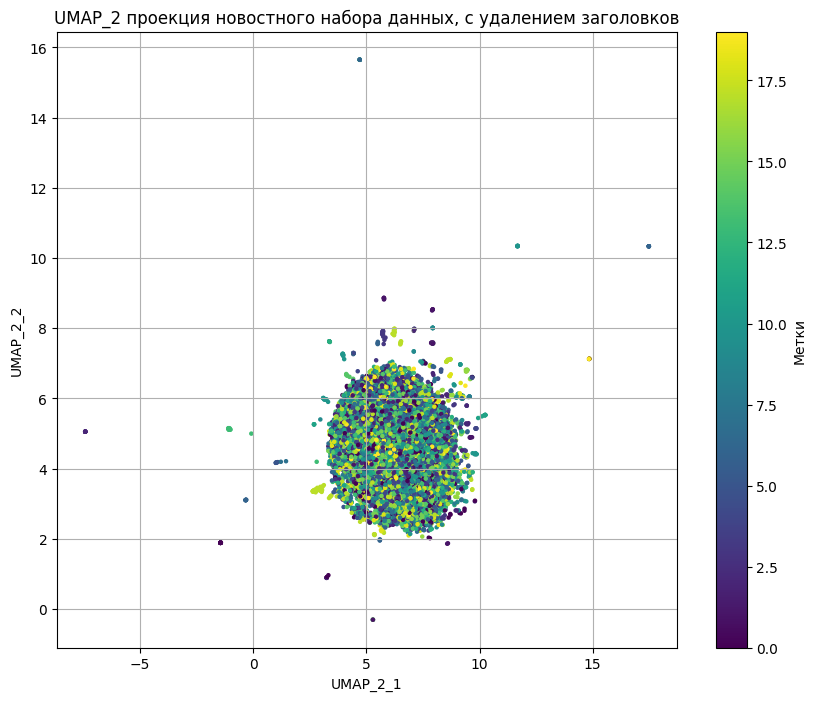

[[0.         0.99167643 0.95734585 1.         1.        ]
 [0.99167643 0.         1.         0.83451053 0.98481586]
 [0.95734585 1.         0.         0.99867233 0.98881003]
 [1.         0.83451053 0.99867233 0.         0.94992837]
 [1.         0.98481586 0.98881003 0.94992837 0.        ]]


In [ ]:
# Инициализация стоп-слов и лемматизатора
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Загрузка данных новостных групп с удалением заголовков, подвалов и цитат
newsgroups_data_2 = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Преобразуем данные в DataFrame
df = pd.DataFrame({'text': newsgroups_data_2.data, 'label': newsgroups_data_2.target})

def preprocess(text):
    '''
    Предобработка входного текста: токенизация, удаление пунктуации, 
    удаление стоп-слов и лемматизация.
    '''
    # Токенизация текста и перевод в нижний регистр
    words = word_tokenize(text.lower())
    # Удаление пунктуации
    words = [word.translate(str.maketrans('', '', string.punctuation)) for word in words]
    # Удаление стоп-слов и фильтрация по алфавиту
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_words)

# Применение функции предобработки к текстовым данным
df['cleaned_text'] = df['text'].apply(preprocess)

# Векторизация текстовых данных с помощью TF-IDF
vectorizer = TfidfVectorizer(max_features=15_000).fit(df['cleaned_text'])
features_2 = vectorizer.transform(df['cleaned_text'])

# Вычисление косинусных расстояний
cosine_distances_matrix = cosine_distances(features_2)

# Понижение размерности с помощью UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(features_2.toarray()) 

# Визуализация результатов
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['label'], cmap='viridis', s=5)
plt.colorbar(scatter, label='Метки') 
plt.title('UMAP_2 проекция новостного набора данных, с удалением заголовков')
plt.xlabel('UMAP_2_1')
plt.ylabel('UMAP_2_2')
plt.grid(True) 
plt.show()

# Пример вывода косинусных расстояний для первых 5 векторов
print(cosine_distances_matrix[:5, :5])

c:\Users\Esdesu\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


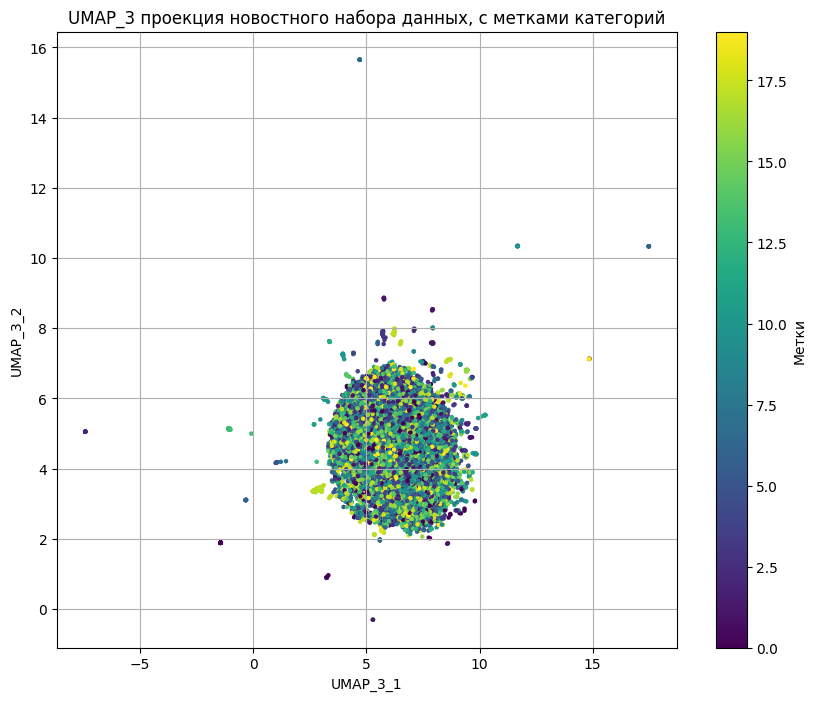

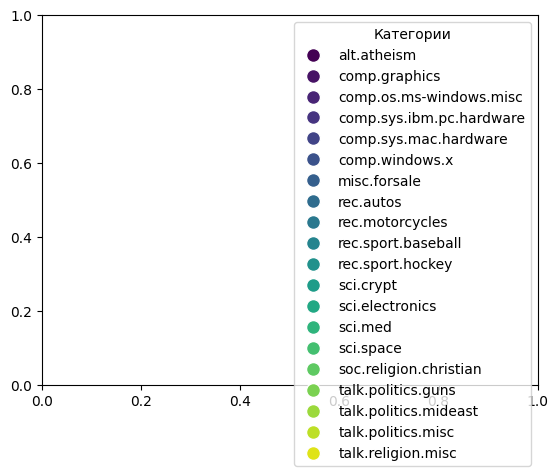

[[0.         0.99167643 0.95734585 1.         1.        ]
 [0.99167643 0.         1.         0.83451053 0.98481586]
 [0.95734585 1.         0.         0.99867233 0.98881003]
 [1.         0.83451053 0.99867233 0.         0.94992837]
 [1.         0.98481586 0.98881003 0.94992837 0.        ]]


In [ ]:

# Инициализация стоп-слов и лемматизатора
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Загрузка данных новостных групп с удалением заголовков, подвалов и цитат
newsgroups_data_3 = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Преобразуем данные в DataFrame
df = pd.DataFrame({'text': newsgroups_data_3.data, 'label': newsgroups_data_3.target})

# Преобразуем числовые метки категорий в строковые названия категорий
category_labels_3 = [newsgroups_data_3.target_names[i] for i in df['label']]

def preprocess(text):
    '''
    Предобработка входного текста: токенизация, удаление пунктуации, 
    удаление стоп-слов и лемматизация.
    '''
    # Токенизация текста и перевод в нижний регистр
    words = word_tokenize(text.lower())
    # Удаление пунктуации
    words = [word.translate(str.maketrans('', '', string.punctuation)) for word in words]
    # Удаление стоп-слов и фильтрация по алфавиту
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_words)

# Применение функции предобработки к текстовым данным
df['cleaned_text'] = df['text'].apply(preprocess)

# Векторизация текстовых данных с помощью TF-IDF
vectorizer = TfidfVectorizer(max_features=15_000).fit(df['cleaned_text'])
features_3 = vectorizer.transform(df['cleaned_text'])

# Вычисление косинусных расстояний
cosine_distances_matrix = cosine_distances(features_3)

# Понижение размерности с помощью UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(features_3.toarray())  # Преобразуем features в массив

# Визуализация результатов
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['label'], cmap='viridis', s=5)
plt.colorbar(scatter, label='Метки') 
plt.title('UMAP_3 проекция новостного набора данных, с метками категорий')
plt.xlabel('UMAP_3_1')
plt.ylabel('UMAP_3_2')
plt.grid(True) 
plt.show()

# Создание легенды
handles = []
for i, category in enumerate(newsgroups_data_3.target_names):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(i / len(newsgroups_data_3.target_names)), markersize=10))
plt.legend(handles, newsgroups_data_3.target_names, title='Категории')
plt.show()

# Пример вывода косинусных расстояний для первых 5 векторов
print(cosine_distances_matrix[:5, :5])

c:\Users\Esdesu\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


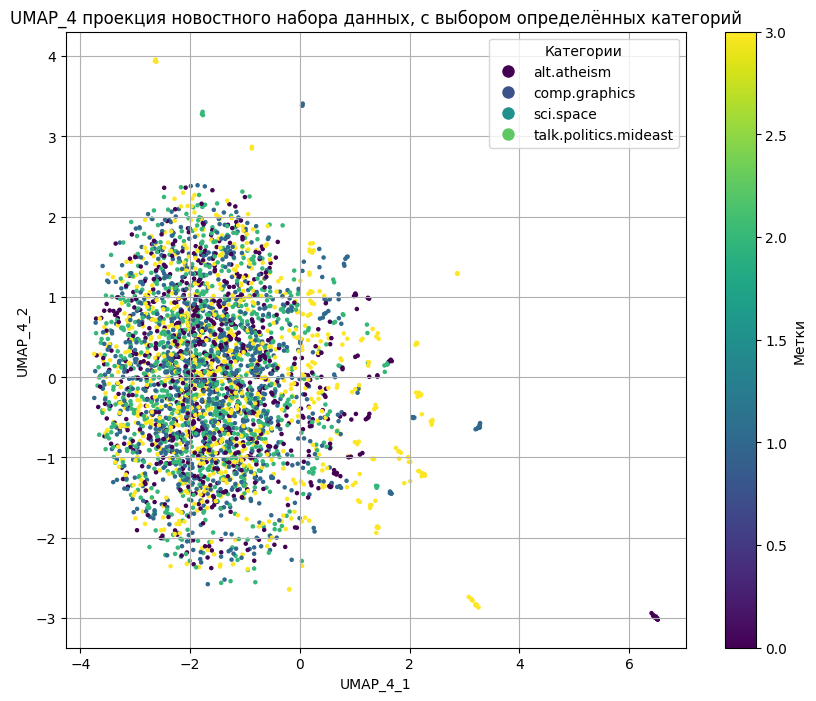

[[0.         1.         1.         1.         1.        ]
 [1.         0.         0.99368169 0.94895174 1.        ]
 [1.         0.99368169 0.         0.99594845 1.        ]
 [1.         0.94895174 0.99594845 0.         0.93274421]
 [1.         1.         1.         0.93274421 0.        ]]


In [ ]:
# Инициализация стоп-слов и лемматизатора
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Выбор определённых категорий
categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.politics.mideast']
# Загрузка данных новостных групп с удалением заголовков, подвалов и цитат
newsgroups_data_4 = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

# Преобразуем данные в DataFrame
df = pd.DataFrame({'text': newsgroups_data_4.data, 'label': newsgroups_data_4.target})

# Преобразуем числовые метки категорий в строковые названия категорий
category_labels_4 = [newsgroups_data_4.target_names[i] for i in df['label']]

def preprocess(text):
    '''
    Предобработка входного текста: токенизация, удаление пунктуации, 
    удаление стоп-слов и лемматизация.
    '''
    # Токенизация текста и перевод в нижний регистр
    words = word_tokenize(text.lower())
    # Удаление пунктуации
    words = [word.translate(str.maketrans('', '', string.punctuation)) for word in words]
    # Удаление стоп-слов и фильтрация по алфавиту
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_words)

# Применение функции предобработки к текстовым данным
df['cleaned_text'] = df['text'].apply(preprocess)

# Векторизация текстовых данных с помощью TF-IDF
vectorizer = TfidfVectorizer(max_features=15_000).fit(df['cleaned_text'])
features_4 = vectorizer.transform(df['cleaned_text'])

# Вычисление косинусных расстояний
cosine_distances_matrix = cosine_distances(features_4)

# Понижение размерности с помощью UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(features_4.toarray())  

# Визуализация результатов
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['label'], cmap='viridis', s=5)
plt.colorbar(scatter, label='Метки')
plt.title('UMAP_4 проекция новостного набора данных, с выбором определённых категорий')
plt.xlabel('UMAP_4_1')
plt.ylabel('UMAP_4_2')
plt.grid(True)

# Добавление легенды для категорий
handles = []
for i, category in enumerate(newsgroups_data_4.target_names):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(i / len(newsgroups_data_4.target_names)), markersize=10))
plt.legend(handles, newsgroups_data_4.target_names, title='Категории')
plt.show()

# Пример вывода косинусных расстояний для первых 5 векторов
print(cosine_distances_matrix[:5, :5])

##### 3. Примените к полученным векторам TF-IDF следующие методы понижения размерности:

— PCA (Principal Component Analysis)

— t-SNE (t-distributed Stochastic Neighbor Embedding)

— UMAP (Uniform Manifold Approximation and Projection).

1. PCA (Principal Component Analysis)

In [138]:
# PCA метод
pca = PCA(n_components=2)
pca_result_1 = pca.fit_transform(features_1.toarray())

In [139]:
# Сколько информации сохранено в первых двух компонентах PCA
explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()
print(f'PCA - Общая объяснительная дисперсия (количество сохраненной информации): {total_explained_variance:.2f}')

PCA - Общая объяснительная дисперсия (количество сохраненной информации): 0.01


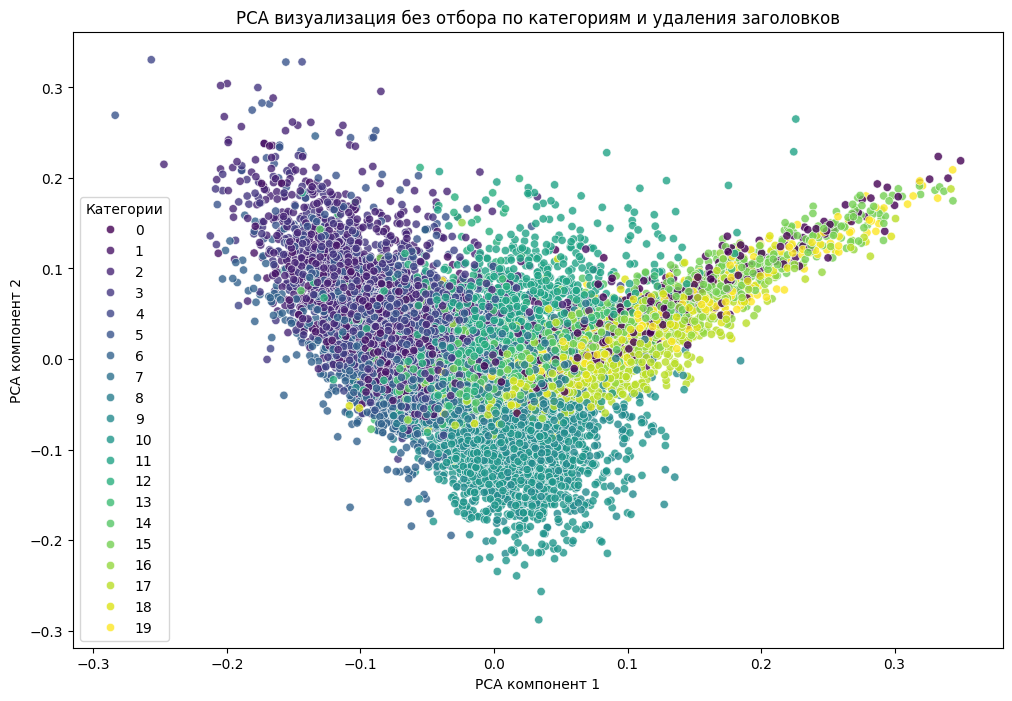

In [140]:
# Создание графика
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_result_1[:, 0], y=pca_result_1[:, 1], hue=newsgroups_data.target, palette='viridis', legend='full', alpha=0.8)

plt.title('PCA визуализация без отбора по категориям и удаления заголовков')
plt.xlabel('PCA компонент 1')
plt.ylabel('PCA компонент 2')
plt.legend(title='Категории')
plt.show()

PCA - Общая объяснительная дисперсия (количество сохраненной информации): 0.01


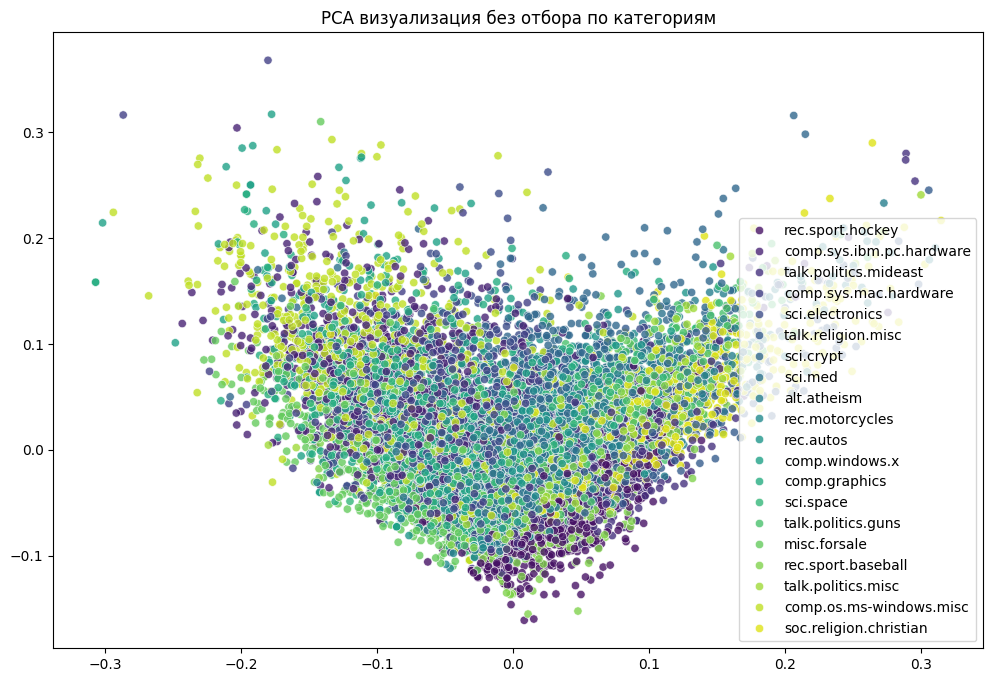

In [142]:
# PCA метод
pca = PCA(n_components=2)
pca_result_3 = pca.fit_transform(features_3.toarray())

# Сколько информации сохранено в первых двух компонентах PCA
explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()
print(f'PCA - Общая объяснительная дисперсия (количество сохраненной информации): {total_explained_variance:.2f}')

# Создание графика
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_result_3[:, 0], y=pca_result_3[:, 1], hue=category_labels_3, palette='viridis', legend='full', alpha=0.8)
plt.title('PCA визуализация без отбора по категориям')
plt.show()


PCA - Общая объяснительная дисперсия (количество сохраненной информации): 0.01


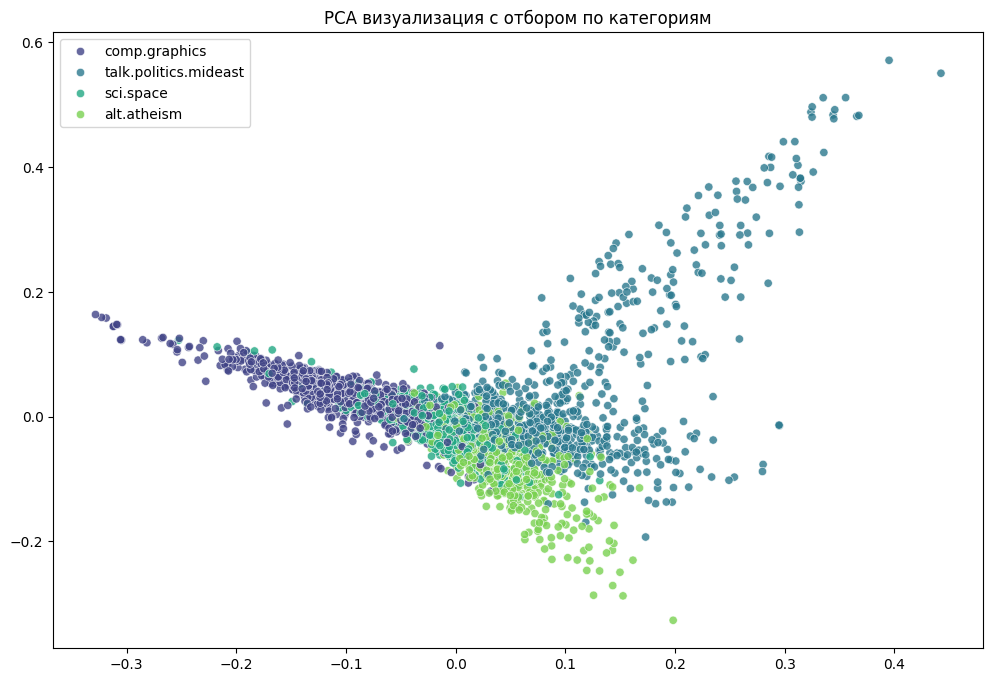

In [143]:
# PCA метод
pca = PCA(n_components=2)
pca_result_4 = pca.fit_transform(features_4.toarray())

# Сколько информации сохранено в первых двух компонентах PCA
explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()
print(f'PCA - Общая объяснительная дисперсия (количество сохраненной информации): {total_explained_variance:.2f}')

# Создание графика
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_result_4[:, 0], y=pca_result_4[:, 1], hue=category_labels_4, palette='viridis', legend='full', alpha=0.8)
plt.title('PCA визуализация с отбором по категориям')
plt.show()

2. t-SNE (t-distributed Stochastic Neighbor Embedding)

In [144]:
# Применение t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result_1 = tsne.fit_transform(features_1.toarray())

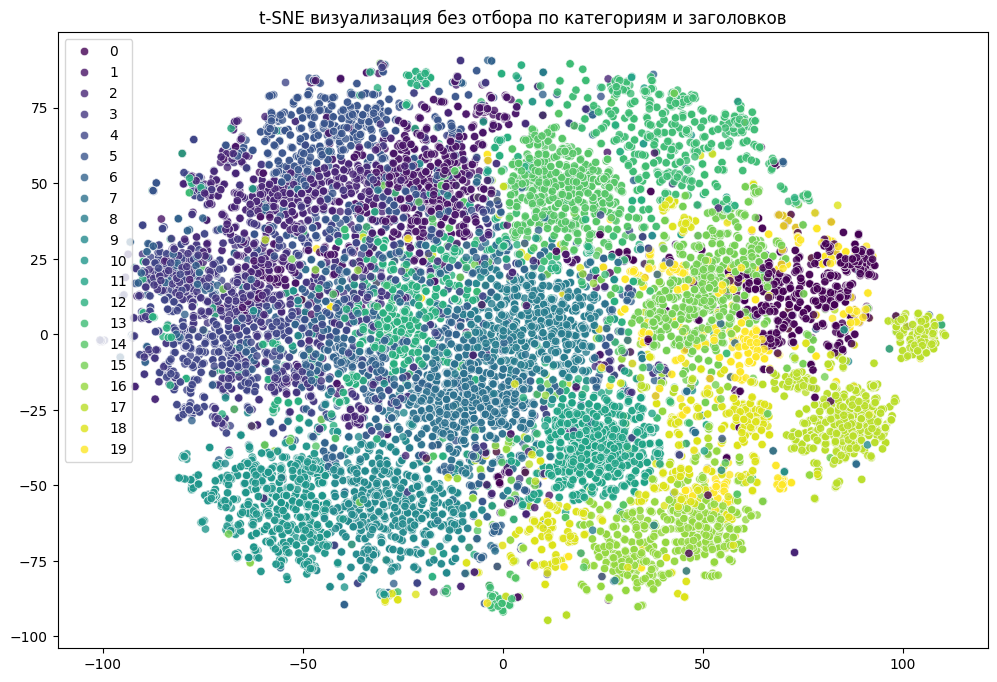

In [150]:
# Создание графика
plt.figure(figsize=(12, 8))
sns.scatterplot(x=tsne_result_1[:, 0], y=tsne_result_1[:, 1], hue=newsgroups_data.target, palette='viridis', legend='full', alpha=0.8)
plt.title('t-SNE визуализация без отбора по категориям и заголовков')
plt.show()

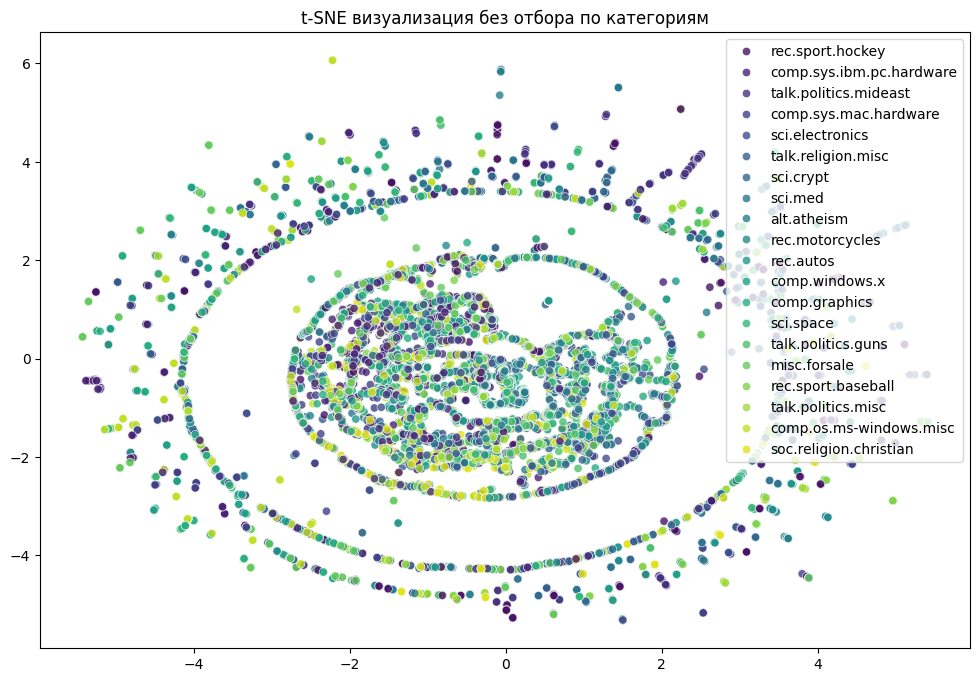

In [148]:
# Применение t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result_3 = tsne.fit_transform(features_3.toarray())

# Создание графика
plt.figure(figsize=(12, 8))
sns.scatterplot(x=tsne_result_3[:, 0], y=tsne_result_3[:, 1], hue=category_labels_3, palette='viridis', legend='full', alpha=0.8)
plt.title('t-SNE визуализация без отбора по категориям')
plt.show()

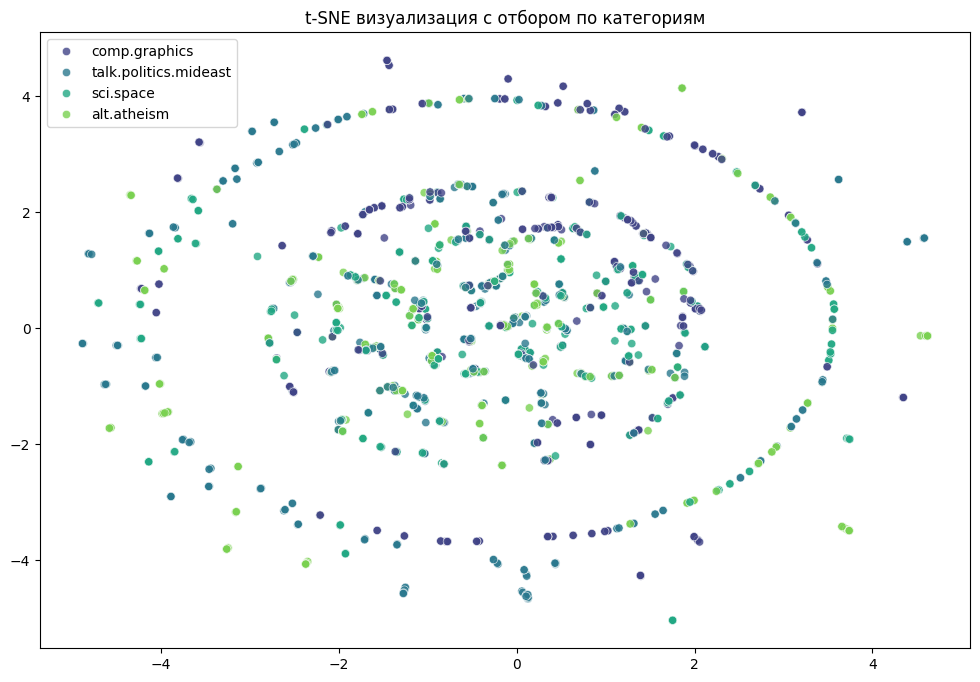

In [ ]:
# Применение t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result_4 = tsne.fit_transform(features_4.toarray())

# Создание графика
plt.figure(figsize=(12, 8))
sns.scatterplot(x=tsne_result_4[:, 0], y=tsne_result_4[:, 1], hue=category_labels_4, palette='viridis', legend='full', alpha=0.8)
plt.title('t-SNE визуализация с отбором по категориям')
plt.show()


3. UMAP (Uniform Manifold Approximation and Projection).

In [ ]:
# Применение UMAP
umap = UMAP(n_components=2, random_state=42)
umap_result_1 = umap.fit_transform(features_1.toarray())

c:\Users\Esdesu\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


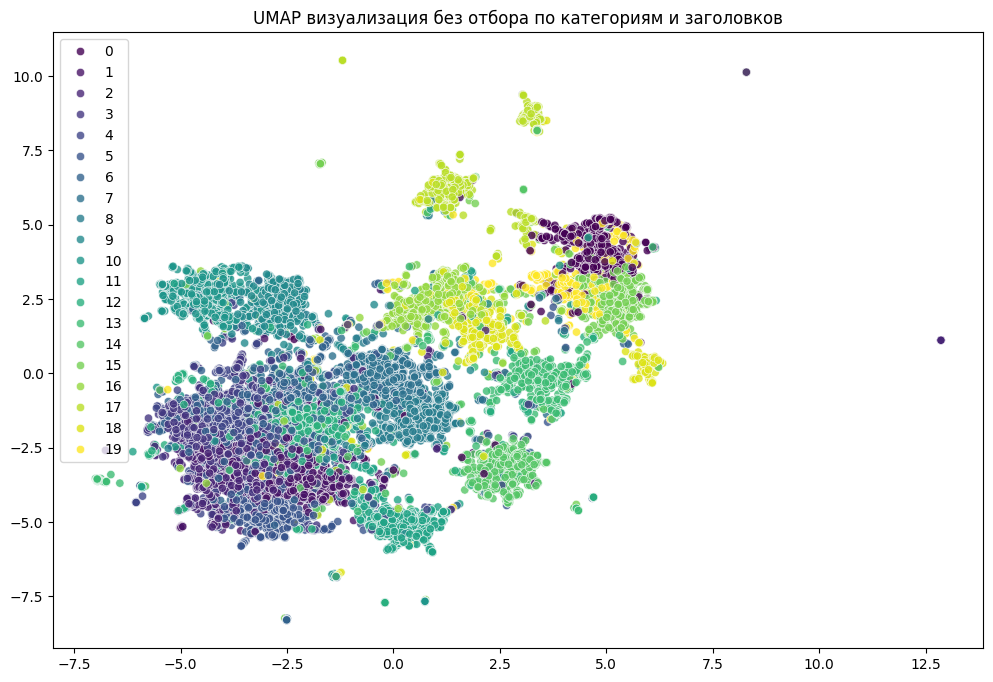

In [153]:
# Создание графика
plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_result_1[:, 0], y=umap_result_1[:, 1], hue=newsgroups_data.target, palette='viridis', legend='full', alpha=0.8)
plt.title('UMAP визуализация без отбора по категориям и заголовков')
plt.show()

c:\Users\Esdesu\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


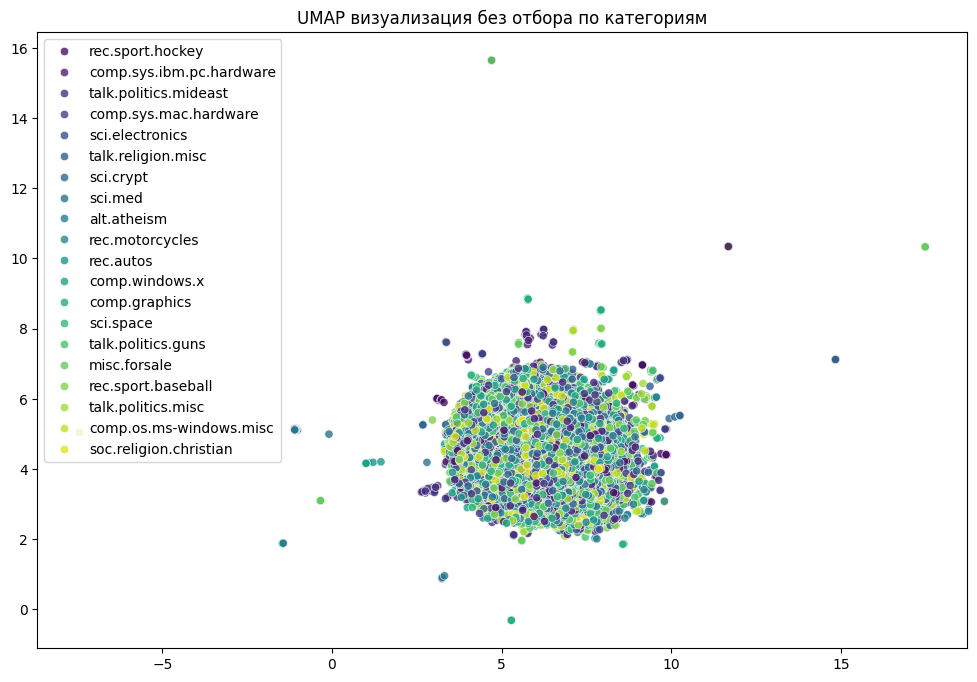

In [157]:
# Применение UMAP
umap = UMAP(n_components=2, random_state=42)
umap_result_3 = umap.fit_transform(features_3.toarray())

# Создание графика
plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_result_3[:, 0], y=umap_result_3[:, 1], hue=category_labels_3, palette='viridis', legend='full', alpha=0.8)
plt.title('UMAP визуализация без отбора по категориям')
plt.show()

c:\Users\Esdesu\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


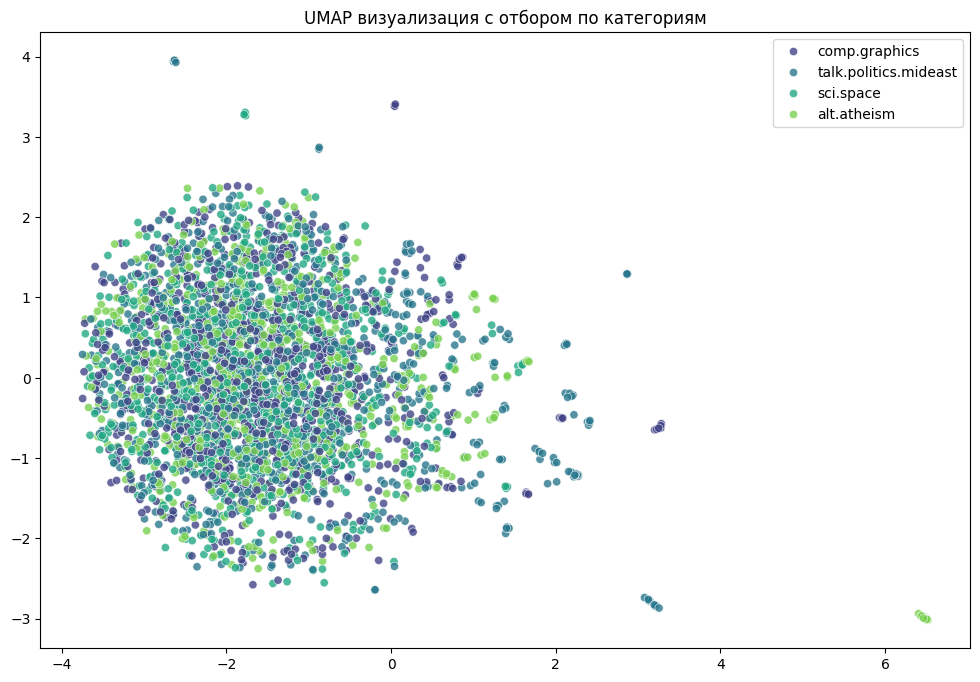

In [158]:
# Применение UMAP
umap = UMAP(n_components=2, random_state=42)
umap_result_4 = umap.fit_transform(features_4.toarray())

# Создание графика
plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_result_4[:, 0], y=umap_result_4[:, 1], hue=category_labels_4, palette='viridis', legend='full', alpha=0.8)
plt.title('UMAP визуализация с отбором по категориям')
plt.show()

##### 4. После понижения размерности данных используйте любой метод машинного обучения для классификации новостей по темам.

In [172]:
# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features_1, newsgroups_data.target, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_result_1, newsgroups_data.target, test_size=0.2, random_state=42)
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(tsne_result_1, newsgroups_data.target, test_size=0.2, random_state=42)
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(umap_result_1, newsgroups_data.target, test_size=0.2, random_state=42)

# Получение размеров данных
def get_shape(X):
    if hasattr(X, 'shape'):
        return X.shape[0]  # Размер первой размерности (количество примеров)
    else:
        return len(X)  # Для плотных матриц

print(f'Разделение на первом наборе без удаления заголовков и выбора категорий:')
print(f'Размер X_train: {get_shape(X_train)}')
print(f'Размер X_test: {get_shape(X_test)}')
print(f'Размер y_train: {len(y_train)}')
print(f'Размер y_test: {len(y_test)}')

print(f'Размер X_train_pca: {get_shape(X_train_pca)}')
print(f'Размер X_test_pca: {get_shape(X_test_pca)}')
print(f'Размер y_train_pca: {len(y_train_pca)}')
print(f'Размер y_test_pca: {len(y_test_pca)}')

print(f'Размер X_train_tsne: {get_shape(X_train_tsne)}')
print(f'Размер X_test_tsne: {get_shape(X_test_tsne)}')
print(f'Размер y_train_tsne: {len(y_train_tsne)}')
print(f'Размер y_test_tsne: {len(y_test_tsne)}')

print(f'Размер X_train_umap: {get_shape(X_train_umap)}')
print(f'Размер X_test_umap: {get_shape(X_test_umap)}')
print(f'Размер y_train_umap: {len(y_train_umap)}')
print(f'Размер y_test_umap: {len(y_test_umap)}')


Разделение на первом наборе без удаления заголовков и выбора категорий:
Размер X_train: 15076
Размер X_test: 3770
Размер y_train: 15076
Размер y_test: 3770
Размер X_train_pca: 15076
Размер X_test_pca: 3770
Размер y_train_pca: 15076
Размер y_test_pca: 3770
Размер X_train_tsne: 15076
Размер X_test_tsne: 3770
Размер y_train_tsne: 15076
Размер y_test_tsne: 3770
Размер X_train_umap: 15076
Размер X_test_umap: 3770
Размер y_train_umap: 15076
Размер y_test_umap: 3770


In [174]:
# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features_3, newsgroups_data_3.target, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_result_3, newsgroups_data_3.target, test_size=0.2, random_state=42)
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(tsne_result_3, newsgroups_data_3.target, test_size=0.2, random_state=42)
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(umap_result_3, newsgroups_data_3.target, test_size=0.2, random_state=42)

# Получение размеров данных
def get_shape(X):
    if hasattr(X, 'shape'):
        return X.shape[0]  # Размер первой размерности (количество примеров)
    else:
        return len(X)  # Для плотных матриц

print(f'Разделение на третьем наборе без выбора категорий:')
print(f'Размер X_train: {get_shape(X_train)}')
print(f'Размер X_test: {get_shape(X_test)}')
print(f'Размер y_train: {len(y_train)}')
print(f'Размер y_test: {len(y_test)}')

print(f'Размер X_train_pca: {get_shape(X_train_pca)}')
print(f'Размер X_test_pca: {get_shape(X_test_pca)}')
print(f'Размер y_train_pca: {len(y_train_pca)}')
print(f'Размер y_test_pca: {len(y_test_pca)}')

print(f'Размер X_train_tsne: {get_shape(X_train_tsne)}')
print(f'Размер X_test_tsne: {get_shape(X_test_tsne)}')
print(f'Размер y_train_tsne: {len(y_train_tsne)}')
print(f'Размер y_test_tsne: {len(y_test_tsne)}')

print(f'Размер X_train_umap: {get_shape(X_train_umap)}')
print(f'Размер X_test_umap: {get_shape(X_test_umap)}')
print(f'Размер y_train_umap: {len(y_train_umap)}')
print(f'Размер y_test_umap: {len(y_test_umap)}')


Разделение на третьем наборе без выбора категорий:
Размер X_train: 15076
Размер X_test: 3770
Размер y_train: 15076
Размер y_test: 3770
Размер X_train_pca: 15076
Размер X_test_pca: 3770
Размер y_train_pca: 15076
Размер y_test_pca: 3770
Размер X_train_tsne: 15076
Размер X_test_tsne: 3770
Размер y_train_tsne: 15076
Размер y_test_tsne: 3770
Размер X_train_umap: 15076
Размер X_test_umap: 3770
Размер y_train_umap: 15076
Размер y_test_umap: 3770


In [175]:
# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features_4, newsgroups_data_4.target, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_result_4, newsgroups_data_4.target, test_size=0.2, random_state=42)
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(tsne_result_4, newsgroups_data_4.target, test_size=0.2, random_state=42)
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(umap_result_4, newsgroups_data_4.target, test_size=0.2, random_state=42)

# Получение размеров данных
def get_shape(X):
    if hasattr(X, 'shape'):
        return X.shape[0]  # Размер первой размерности (количество примеров)
    else:
        return len(X)  # Для плотных матриц

print(f'Разделение на четвёртом наборе с выбором категорий:')
print(f'Размер X_train: {get_shape(X_train)}')
print(f'Размер X_test: {get_shape(X_test)}')
print(f'Размер y_train: {len(y_train)}')
print(f'Размер y_test: {len(y_test)}')

print(f'Размер X_train_pca: {get_shape(X_train_pca)}')
print(f'Размер X_test_pca: {get_shape(X_test_pca)}')
print(f'Размер y_train_pca: {len(y_train_pca)}')
print(f'Размер y_test_pca: {len(y_test_pca)}')

print(f'Размер X_train_tsne: {get_shape(X_train_tsne)}')
print(f'Размер X_test_tsne: {get_shape(X_test_tsne)}')
print(f'Размер y_train_tsne: {len(y_train_tsne)}')
print(f'Размер y_test_tsne: {len(y_test_tsne)}')

print(f'Размер X_train_umap: {get_shape(X_train_umap)}')
print(f'Размер X_test_umap: {get_shape(X_test_umap)}')
print(f'Размер y_train_umap: {len(y_train_umap)}')
print(f'Размер y_test_umap: {len(y_test_umap)}')


Разделение на четвёртом наборе с выбором категорий:
Размер X_train: 2959
Размер X_test: 740
Размер y_train: 2959
Размер y_test: 740
Размер X_train_pca: 2959
Размер X_test_pca: 740
Размер y_train_pca: 2959
Размер y_test_pca: 740
Размер X_train_tsne: 2959
Размер X_test_tsne: 740
Размер y_train_tsne: 2959
Размер y_test_tsne: 740
Размер X_train_umap: 2959
Размер X_test_umap: 740
Размер y_train_umap: 2959
Размер y_test_umap: 740


##### 5. Сравните качество классификации для каждого метода понижения размерности. Используйте метрики точности и F1-меру.

In [176]:
# Функция для обучения модели и оценки метрик
def evaluate_model(X_train, X_test, y_train, y_test):
    classifier = LogisticRegression(max_iter=1000, random_state=42)

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    #average='weighted' - взвешенное среднее
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, f1

In [177]:
accuracy, f1 = evaluate_model(X_train, X_test, y_train, y_test)
accuracy_pca, f1_pca = evaluate_model(X_train_pca, X_test_pca, y_train_pca, y_test_pca)
accuracy_tsne, f1_tsne = evaluate_model(X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne)
accuracy_umap, f1_umap = evaluate_model(X_train_umap, X_test_umap, y_train_umap, y_test_umap)

print(f'Без понижения размерности - Accuracy: {accuracy:.2f}, F1-score: {f1:.2f}')
print(f'PCA - Accuracy: {accuracy_pca:.2f}, F1-score: {f1_pca:.2f}')
print(f't-SNE - Accuracy: {accuracy_tsne:.2f}, F1-score: {f1_tsne:.2f}')
print(f'UMAP - Accuracy: {accuracy_umap:.2f}, F1-score: {f1_umap:.2f}')


NameError: name 'f1_score' is not defined

##### 6. Визуализируйте двумерное представление данных для каждого метода понижения размерности, чтобы оценить, как алгоритмы справляются с сепарацией классов.

##### 7. Напишите отчёт, в котором обсудите, какой метод понижения размерности оказал наиболее значительное влияние на качество классификации и почему.